In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from scipy.optimize import fmin_slsqp
from msmr.jupyter.utilities import msmr as msmr

plt.style.use('default')
sns.set_context("talk")

Luis graciously provided us with some data, but the data file does not have a cycle number to index, which means we have to do a little more manual scrubbing

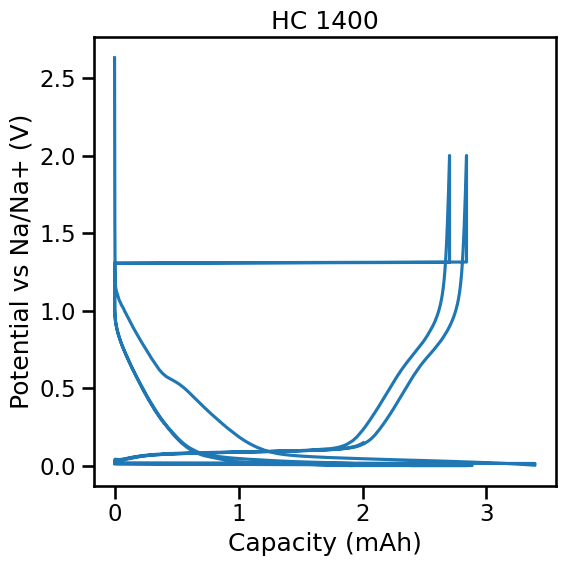

In [2]:
data = pd.read_csv('Data/Na_ion_Luis/HC_1400_1_C06.txt', sep = '\t')
data = data.drop(index = np.arange(1801), columns ='Unnamed: 3')
data.columns = ["Time (s)", "Voltage (V)", "Capacity (mAh)"]

plt.figure(figsize=(6,6))
plt.plot(data['Capacity (mAh)'], data['Voltage (V)'])
plt.ylabel('Potential vs Na/Na+ (V)')
plt.xlabel('Capacity (mAh)')
plt.title('HC 1400')

plt.tight_layout()

# Part 1: Labelling the data

I'd like to be able to pick and choose which curve I'm modeling 

In [3]:
# assuming that the first cycle will be a charge cycle,
# if the voltage is >= 2 V, 
# label all the data between this range as cycle number i+1
# continue to the next iteration
# next iteration will be a discharge cycle 
# for discharge, store all numbers between 2 and 0
# if voltage is <= 0, continue

# i'm thinking that the cycle number is i+1
# odd cycle numbers = charge
# even cycle numbers = discharge

a,b = data.shape
cycle_num = 1
data_index = []

for i in range(a):
    # if the cycle number is odd, it's a charge cycle
    if cycle_num % 2 != 0:
        if data['Voltage (V)'].iloc[i] > 5E-3:
            data_index.append(cycle_num)
        elif data['Voltage (V)'].iloc[i] <= 5E-3:
            data_index.append(cycle_num)
            cycle_num += 1
            continue
            
    # if the cycle number is even, it's a discharge cycle        
    elif cycle_num % 2 == 0:
        if data['Voltage (V)'].iloc[i] < 2:
            data_index.append(cycle_num)
        elif data['Voltage (V)'].iloc[i] >= 2:
            data_index.append(cycle_num)
            cycle_num += 1
            continue

In [4]:
test_data = data.assign(Cycle=data_index)
test_data= test_data.set_index('Cycle')
test_data

,Time (s),Voltage (V),Capacity (mAh)
Cycle,,,
1,1800.000355,2.630591,1.326392e-08
1,1810.000354,2.335990,3.580277e-04
1,1820.000354,2.120912,7.160579e-04
1,1830.000354,1.952046,1.074097e-03
1,1840.000354,1.812624,1.432113e-03
...,...,...,...
6,514812.254763,0.146738,2.003793e+00
6,514822.254956,0.146887,2.004151e+00
6,514832.255148,0.147040,2.004510e+00


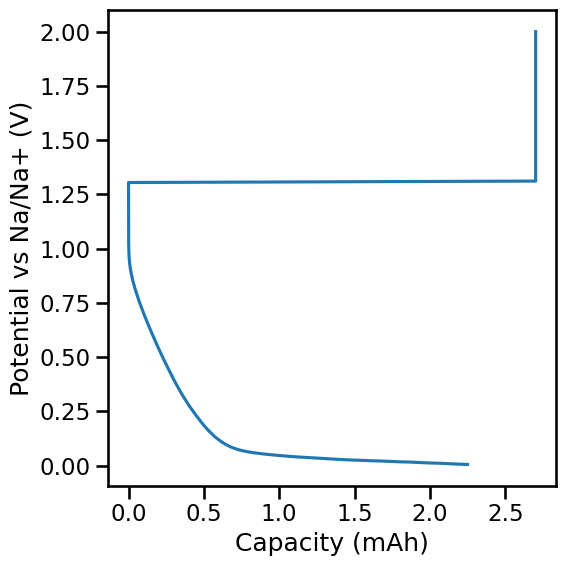

In [5]:
cycle = 3
plt.figure(figsize=(6,6))
plt.plot(test_data.loc[cycle]['Capacity (mAh)'], test_data.loc[cycle]['Voltage (V)'])
plt.ylabel('Potential vs Na/Na+ (V)')
plt.xlabel('Capacity (mAh)')
#plt.title('HC 1400')

plt.tight_layout()

# Part 2: Cleaning the data

The model will not work very well with the plateaus

In [6]:
# # New idea
# # it's almost the same as above, but instead of appending the elements that pass
# # i'm dropping elements that don't pass

# cleaned_data = test_data.loc[1]

# cycle = 2
# for i in range(test_data.loc[1].shape[0], test_data.shape[0]):
    
#     # for the discharge cycles, we want to get rid of the zero volt plateaus
#     # starts at low potentials
#     if cycle % 2 == 0:
#         if test_data.iloc[i,1] <= 1.5E-2:
#             continue
#         elif test_data.iloc[i,1] > 1.5E-2 and test_data.iloc[i,1] <= 1.245:
#             cleaned_data = cleaned_data.append(test_data.iloc[i])
            
#         elif test_data.iloc[i,1] > 1.245:
#             cycle += 1
#             continue
#     # for the charge cycles after the first one
#     # we will only analyze the data below 1.25 V
#     # we might have to switch around the first and last conditions
#     else:
#         if test_data.iloc[i,1] > 1.25:
#             continue
            
#         elif test_data.iloc[i,1] <= 1.25 and test_data.iloc[i,1] > 1E-3:
#             cleaned_data = cleaned_data.append(test_data.iloc[i])
        
#         elif test_data.iloc[i,1] <= 1E-3:
#             cycle += 1
#             continue

In [7]:
# cleaned_data.loc[3]

In [8]:
# if you want to create a txt file with the data
# thanks to: https://www.statology.org/pandas-to-text-file/
# i changed the code from ^^ to create a csv

# path = 'Data/Na_ion_Luis/HC_1400_cleaned.csv'

# with open(path, 'a') as f:
#     df_csv = cleaned_data.to_csv()
#     f.write(df_csv)

In [9]:
# cycle = 3
# plt.figure(figsize=(6,6))
# plt.plot(cleaned_data.loc[cycle]['Capacity (mAh)'], cleaned_data.loc[cycle]['Voltage (V)'])
# plt.ylabel('Potential vs Na/Na+ (V)')
# plt.xlabel('Capacity (mAh)')
# #plt.title('HC 1400')

# plt.tight_layout()

In [10]:
HC_1400_exp = pd.read_csv('Data/Na_ion_Luis/HC_1400_cleaned.csv', index_col = 0)
HC_1400_exp.head(5)

,Time (s),Voltage (V),Capacity (mAh)
Cycle,,,
1,1800.000355,2.630591,1.326392e-08
1,1810.000354,2.335990,3.580277e-04
1,1820.000354,2.120912,7.160579e-04
1,1830.000354,1.952046,1.074097e-03
1,1840.000354,1.812624,1.432113e-03


In [11]:
HC_1400_exp.loc[3]['Voltage (V)'].min()

0.0050000604

# Finally, we start the modeling process
# Experimental Data 

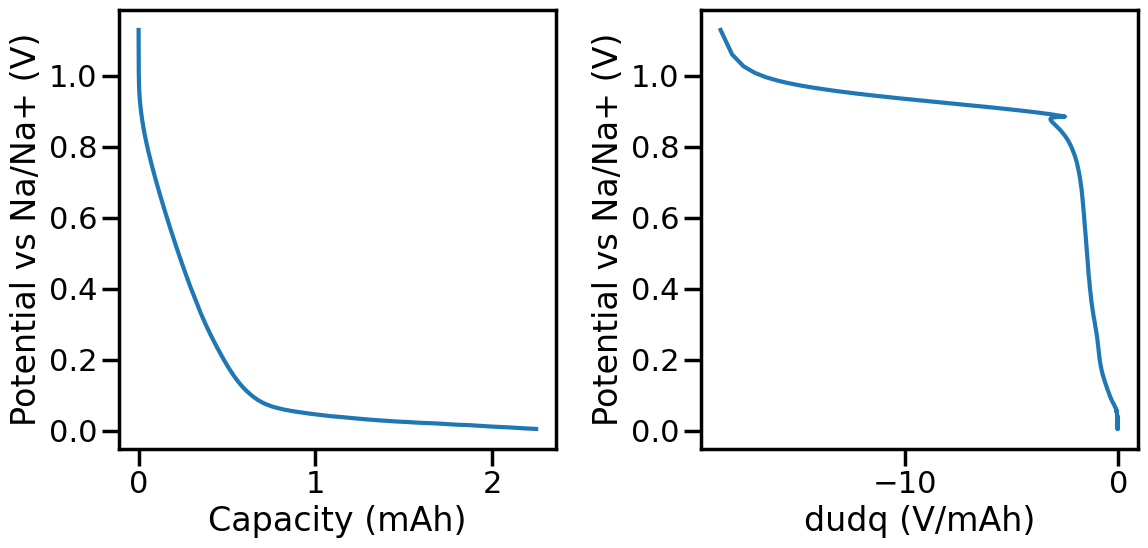

In [12]:
path = 'Data/Na_ion_Luis/HC_1400_cleaned.csv'

current_density = 15 # uA/mg
AM_1400 = 8.62 # active material mass in mg
cc_1400 = current_density * 1E-3 * AM_1400 # constant current value in mA

v_range = np.linspace(6E-3, 1.1, 1000)

V_1400, I, Q_1400, dudq_1400, Q_1400_interp, dudq_1400_interp = msmr.load_experiment_data(filepath = path, 
                                                                                     cycle_num = 3, 
                                                                                     constant_current = cc_1400, 
                                                                                     timestep = 10, 
                                                                                     sf_window_length = 99, 
                                                                                     interpolated_voltage_range= v_range, 
                                                                                     charge = True)
sns.set_context("poster")
fig, ax = plt.subplots(1,2, figsize = (12,6), tight_layout = True)
#fig.suptitle('Cell 1 Experimental Data')

#ax[0].set_title('HC 1400 Cycle 3')
ax[0].set_xlabel('Capacity (mAh)')
ax[0].set_ylabel('Potential vs Na/Na+ (V)')
ax[0].plot(Q_1400, V_1400, label = 'Experimental')
#ax[0].plot(Q_1400_interp, v_range, '--', label = 'Interpolated')
#ax[0].legend()

#ax[1].set_title('Cell 1 Charge diffCap')
ax[1].set_xlabel('dudq (V/mAh)')
ax[1].set_ylabel('Potential vs Na/Na+ (V)')
ax[1].plot(dudq_1400, V_1400)

plt.show()

# Making the Na-ion MSMR model

/mnt/c/users/Rose/OneDrive - UW/Desktop/UW PhD/2022 Summer/RLee_MSMR/msmr/jupyter/utilities/msmr.py:144: RuntimeWarning: overflow encountered in square
  dxjdu = (-Xj/w)*((f*np.exp(f*(U-U0)/w))/(1+np.exp(f*(U-U0)/w))**2)


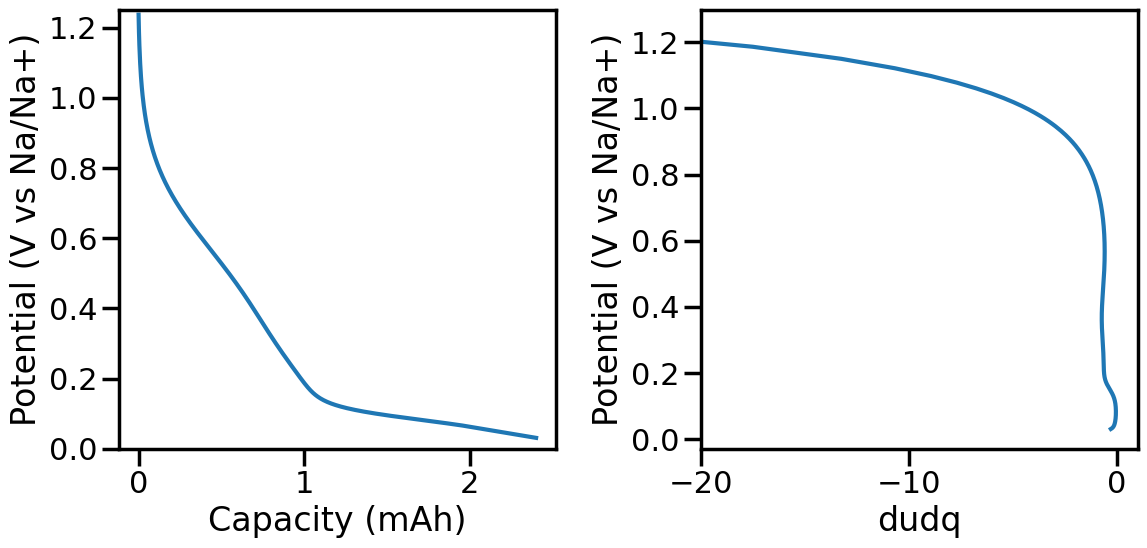

In [13]:
AM_1400 = 8.62 # active material mass in mg
p_cap = 278.5 # mA/mg
p_cap = p_cap * AM_1400 # mA

# i'm not sure why, but the model is 3 orders of magnitude higher
# so i'm adding this for the sake of fitting

mod = 1E-3
p_cap = p_cap * mod

Na_ref = np.array([-1E-5, 0.5*p_cap, 0.1,
                   1E-5, 0.5*p_cap, 0.1])


hard_carbon_matrix = np.array([0.08, 0.5*p_cap, 0.7,
                               0.2, 0.15*p_cap, 3,
                              0.57, 0.35*p_cap, 5])

params = np.append(hard_carbon_matrix, Na_ref)

Q_1400_IM, V_1400_IM, dqdu_1400_IM, dudq_1400_IM = msmr.whole_cell(parameter_matrix = params, 
                                    nor_pos = 3, nor_neg = 2,
                                    pos_lower_li_limit = 0.005, neg_lower_li_limit = 1,
                                    temp = 298, 
                                    pos_volt_range = (0.06, 1.25), neg_volt_range = (0.00, 1),
                                    usable_cap = p_cap, Qj_or_Xj= 'Qj', 
                                    n_p= 1000, p_capacity= 0.5,
                                    all_output= True)

fig, ax = plt.subplots(1,2, figsize = (12,6), tight_layout = True)

ax[0].set_xlabel('Capacity (mAh)')
ax[0].set_ylabel('Potential (V vs Na/Na+)')
ax[0].plot(np.flip(Q_1400_IM[0]), V_1400_IM[0], linewidth = 3)
ax[0].set_ylim(0, 1.25)

ax[1].set_xlabel('dudq')
ax[1].set_ylabel('Potential (V vs Na/Na+)')
ax[1].plot(dudq_1400_IM[0], V_1400_IM[0], linewidth = 3)
ax[1].set_xlim(-20, 1)

plt.show()

# Comparing experimental data to the initial model

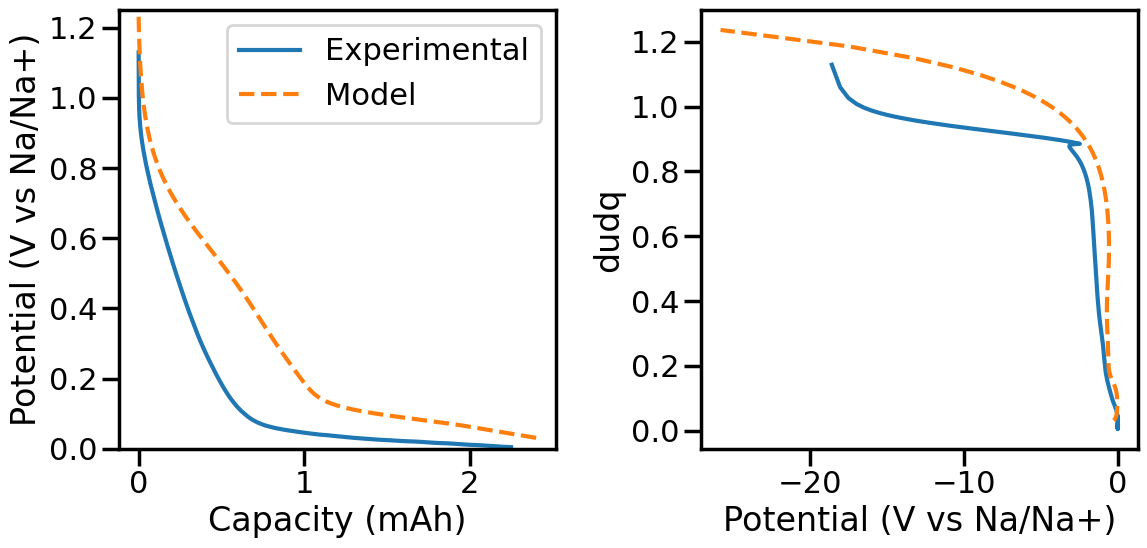

In [14]:
fig, ax = plt.subplots(1,2, figsize = (12,6), tight_layout = True)

ax[0].set_xlabel('Capacity (mAh)')
ax[0].set_ylabel('Potential (V vs Na/Na+)')
ax[0].plot(Q_1400, V_1400, label = 'Experimental')
ax[0].plot(np.flip(Q_1400_IM[0]), V_1400_IM[0], '--', label = 'Model')
ax[0].set_ylim(0, 1.25)
ax[0].legend()

ax[1].set_ylabel('dudq')
ax[1].set_xlabel('Potential (V vs Na/Na+)')
ax[1].plot(dudq_1400, V_1400, label = 'Experimental')
ax[1].plot(dudq_1400_IM[0], V_1400_IM[0], '--', label = 'Model')

plt.show()

# Adjusting the initial model

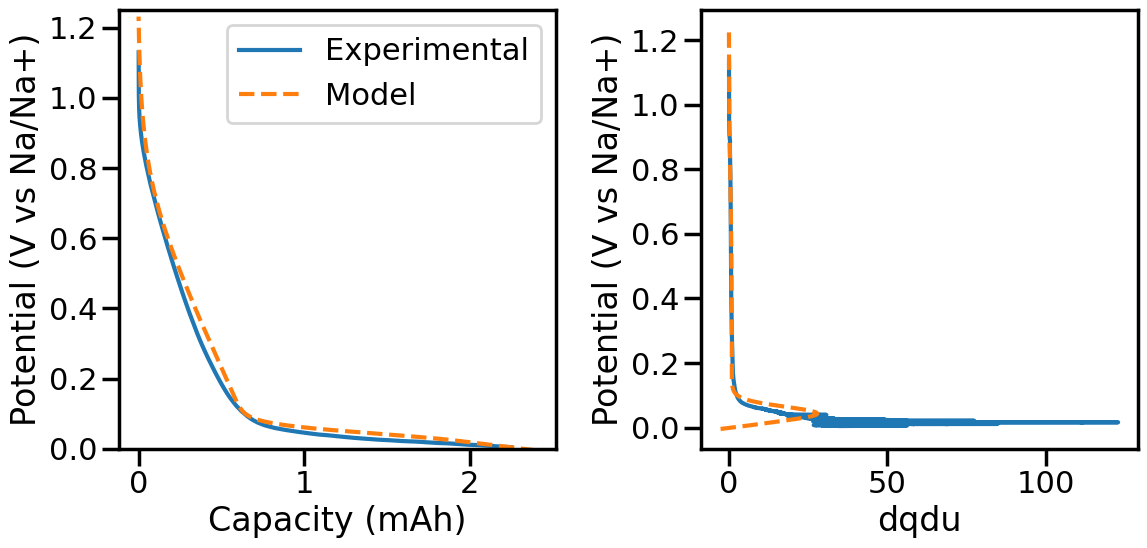

In [15]:
hard_carbon_matrix = np.array([0.04, 0.65*p_cap, 0.5,
                               0.15, 0.2*p_cap, 6,
                              0.55, 0.15*p_cap, 6])

params = np.append(hard_carbon_matrix, Na_ref)

Q_1400_IM, V_1400_IM, dqdu_1400_IM, dudq_1400_IM = msmr.whole_cell(parameter_matrix = params, 
                                    nor_pos = 3, nor_neg = 2,
                                    pos_lower_li_limit = 0.005, neg_lower_li_limit = 1,
                                    temp = 298, 
                                    pos_volt_range = (0.02, 1.25), neg_volt_range = (0.00, 1),
                                    usable_cap = p_cap, Qj_or_Xj= 'Qj', 
                                    n_p= 1000, p_capacity= 0.5,
                                    all_output= True)

fig, ax = plt.subplots(1,2, figsize = (12,6), tight_layout = True)

ax[0].set_xlabel('Capacity (mAh)')
ax[0].set_ylabel('Potential (V vs Na/Na+)')
ax[0].plot(Q_1400, V_1400, label = 'Experimental')
ax[0].plot(np.flip(Q_1400_IM[0]), V_1400_IM[0], '--', label = 'Model')
ax[0].set_ylim(0, 1.25)
ax[0].legend()

ax[1].set_xlabel('dqdu')
ax[1].set_ylabel('Potential (V vs Na/Na+)')
ax[1].plot(-1/dudq_1400, V_1400, label = 'Experimental')
ax[1].plot(-1/dudq_1400_IM[0], V_1400_IM[0], '--', label = 'Model')

plt.show()

# Fitting the model to the data

In [16]:
fresh_ocv_bounds = []
nor_pos, nor_neg = 3,2

# fresh_guess = [working electrode, reference electrode, lower Li bounds]

Na_bounds = np.array([0,0])
fresh_guess = np.append(params, Na_bounds)

# adjusting working electrode (graphite) bounds
for i in range(0,int(nor_pos)):
    fresh_ocv_bounds.append((fresh_guess[i*3] - 0.05, fresh_guess[i*3] + 0.05))
    fresh_ocv_bounds.append((fresh_guess[i*3 + 1]*0.75, fresh_guess[i*3 + 1]*1.25))
    fresh_ocv_bounds.append((fresh_guess[i*3 + 2]*0.75, fresh_guess[i*3 + 2]*1.25))
    
# fixing reference electrode bounds
# only letting them vary by 1%
for i in range(int(nor_pos),int(nor_pos+nor_neg)):
    fresh_ocv_bounds.append((fresh_guess[i*3]-1E-6, fresh_guess[i*3]+1E-6))
    fresh_ocv_bounds.append((fresh_guess[i*3 + 1]*0.999, fresh_guess[i*3 + 1]*1.001))
    fresh_ocv_bounds.append((fresh_guess[i*3 + 2]*0.999, fresh_guess[i*3 + 2]*1.001))
               
fresh_ocv_bounds.append((0, 0.0108)) # lower Li bounds for graphite
fresh_ocv_bounds.append((0.005, 0.01)) # ^^ reference electrode

# set the + and - volt range to be the same
#voltage_range_c = np.linspace(0.05, 1.6, 2000)
fit_params_1400_c3 = fmin_slsqp(func=msmr.verbrugge_whole_cell_opt, x0=fresh_guess, 
                        args=(v_range,             # interpolated voltage range
                              Q_1400_interp,       # interpolated capacity data
                              dudq_1400_interp,     # interpolated dudq data
                              V_1400.min(),   # Minimum voltage
                              V_1400.max(),   # Maximum voltage
                              298,                       # temperature
                              3, 2,                      # number of pos rxns, number of neg rxns
                              (0.0, 1.25), (0,1),            # positive voltage range, negative voltage range
                              0.005, 1,                 # positive | neg lower X or Q limit
                              None,                      # N|P Ratio
                              None,                      # positive electrode full capacity
                              Q_1400.max(),  # usable/cyclable capacity within the voltage limits
                              'Qj', 'MAE',              # Qj or Xj
                              None,                      # list of pos_U0s
                              [-1E-6, 1E-6],                      # list of neg_U0s
                              False, False,               # fixed voltage | fixed Xj or Qj limit
                              0.5, 0.5),                 # capacity vs dudq weight on error function
                        eqcons=[msmr.lower_v_constraint, msmr.upper_v_constraint],
                        bounds=fresh_ocv_bounds, iter=500, full_output=False)

fit1_params = fit_params_1400_c3[0:(nor_pos+nor_neg)*3]
splitTest = np.split(fit1_params, nor_pos+nor_neg)
df = pd.DataFrame(splitTest, columns = ['U0', 'Qj', 'w'], index = ['HC 1400', 'HC 1400', 'HC 1400', 'Na_ref', 'Na_ref'])
df

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.684335749889126
            Iterations: 11
            Function evaluations: 199
            Gradient evaluations: 11


,U0,Qj,w
HC 1400,0.090000,1.398951,0.62500
HC 1400,0.200000,0.600167,7.50000
HC 1400,0.600000,0.450126,4.72999
Na_ref,-0.000011,1.199135,0.10010
Na_ref,0.000009,1.199135,0.10010


/mnt/c/users/Rose/OneDrive - UW/Desktop/UW PhD/2022 Summer/RLee_MSMR/msmr/jupyter/utilities/msmr.py:144: RuntimeWarning: overflow encountered in square
  dxjdu = (-Xj/w)*((f*np.exp(f*(U-U0)/w))/(1+np.exp(f*(U-U0)/w))**2)


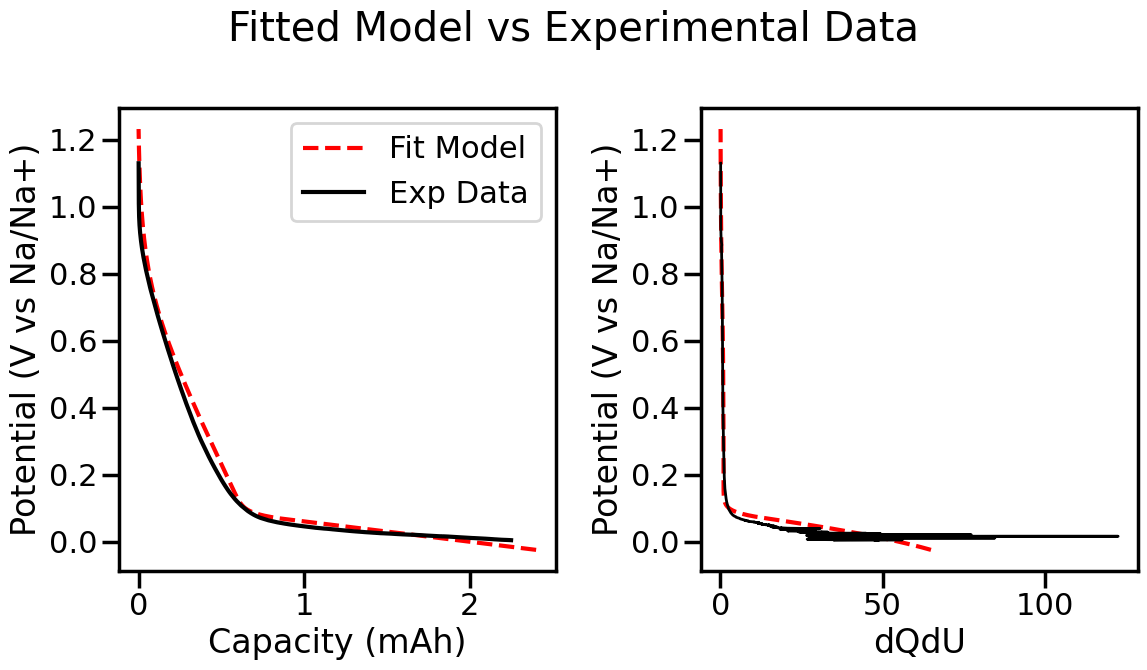

In [17]:
Q_1400_fit, V_1400_fit, dqdu_1400_fit, dudq_1400_fit = msmr.whole_cell(parameter_matrix = params, 
                                    nor_pos = 3, nor_neg = 2,
                                    pos_lower_li_limit = 0.005, neg_lower_li_limit = 1,
                                    temp = 298, 
                                    pos_volt_range = (0.06, 1.25), neg_volt_range = (0.00, 1),
                                    usable_cap = p_cap, Qj_or_Xj= 'Qj', 
                                    n_p= 1000, p_capacity= 0.5,
                                    all_output= True)

# Comparing model to experimental data

fig2, ax = plt.subplots(1,2, figsize = (12,7), tight_layout = True)
# 0 = full cell
# 1 = cathode
# 2 = anode
fig2.suptitle('Fitted Model vs Experimental Data')

ax[0].set_xlabel('Capacity (mAh)')
ax[0].set_ylabel('Potential (V vs Na/Na+)')
ax[0].plot(np.flip(Q_1400_fit[0]), V_1400_fit[0], linewidth = 3, linestyle = 'dashed', color = 'r', label = 'Fit Model')
ax[0].plot(Q_1400, V_1400, linewidth = 3, color = 'k', label = 'Exp Data')
#ax[0].set_ylim(-0.2,1)
ax[0].legend()

ax[1].set_xlabel('dQdU')
ax[1].set_ylabel('Potential (V vs Na/Na+)')
#ax[1].set_xlim(0, 0.5)
#ax[1].set_ylim(-0.5, 5)
ax[1].plot(-1/dudq_1400_fit[0], V_1400_fit[0], linestyle = 'dashed', color = 'r')
ax[1].plot(-1/dudq_1400, V_1400, linewidth = 2, color = 'k')

plt.tight_layout()
plt.show()